# Full Workflow {.unnumbered} 

In this we will go through the basic structure of the analysis, as well as the results. The code in this Notebook is only used to compile the results and evaluate them. The code used to generate the results is found in the executable scripts and function scripts following this notebook.  

If you want to reproduce the results go to the according [Gitlab repository](https://git.sc.uni-leipzig.de/ss2024-12-geo-m-ds02/sif-prediction).

</br>

## Setup 


Throughout the scripts some functions and variables are used multiple times. These functions and variables were defined in config.py and utils.py.


From the config script we use the variables, the latitude and longitude range as well as a time range to subset our datacube, containg climatic data and SIF data.

Details: [Config](#sec-config)


The two most important functions from utils are:

- create_paths() from utils to create paths necessary throughout the analysis.
  
- create_subset() to create a subset of the Earth System Data Cube, croped to:

  - our AOI, the extent of germany 

  - the time span where the SIF variable is avaialble 

  - to the relevant variables

Details: [Utility functions](#sec-utils)
  

In [29]:
import sys
import os
import geopandas as gpd
import xarray as xr
import rioxarray as rio
import json
import numpy as np
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join('scripts')))

# from scripts.config import *
from scripts.utils import create_cube_subset, create_paths
from scripts.s03_base_analysis import base_analysis, change_plot, plot_timeseries
from scripts.config import variables
from scripts.modelling_functions import plot_multiple_results;
import matplotlib.pyplot as plt


***

**Here you can see the subsetted cube**

In [31]:
# Create a data directory
data_path = "data"
os.makedirs(data_path, exist_ok=True)

# Create paths to the data
germany_shp_path, corine_file_path, cube_sample_path, cube_crop_path, cube_crop_mask_path = create_paths(data_path=data_path)

# Create a subset of the Earth System Data Cube, containing only relevant variables and the desired spatial and temporal extent
cube_subset = create_cube_subset()

# remove attributes
cube_subset.attrs = {}

print(cube_subset)

<xarray.Dataset> Size: 30MB
Dimensions:                 (time: 920, lat: 31, lon: 37)
Coordinates:
  * lat                     (lat) float64 248B 47.38 47.62 47.88 ... 54.62 54.88
  * lon                     (lon) float64 296B 5.875 6.125 6.375 ... 14.62 14.88
  * time                    (time) datetime64[ns] 7kB 2002-01-05 ... 2021-12-31
    spatial_ref             int64 8B 0
Data variables:
    sif_gosif               (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    evaporation_era5        (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    precipitation_era5      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    radiation_era5          (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    air_temperature_2m      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    max_air_temperature_2m  (time, lat, lon) float32 4

</br>

## Downloading auxillary data

The first part of the analysis is to download and preprocess all the necassaty auxillary data:

- download german border shapefile
- download and preprocess Corine data for the year 2000 (for the forest mask)
- create sif sample tif for spatial resolution and transform (used later to resample corine data)

Details: [2 Loading auxillary data](#sec-load_aux)

***

**Plot showing the Corine Forest Cover data**

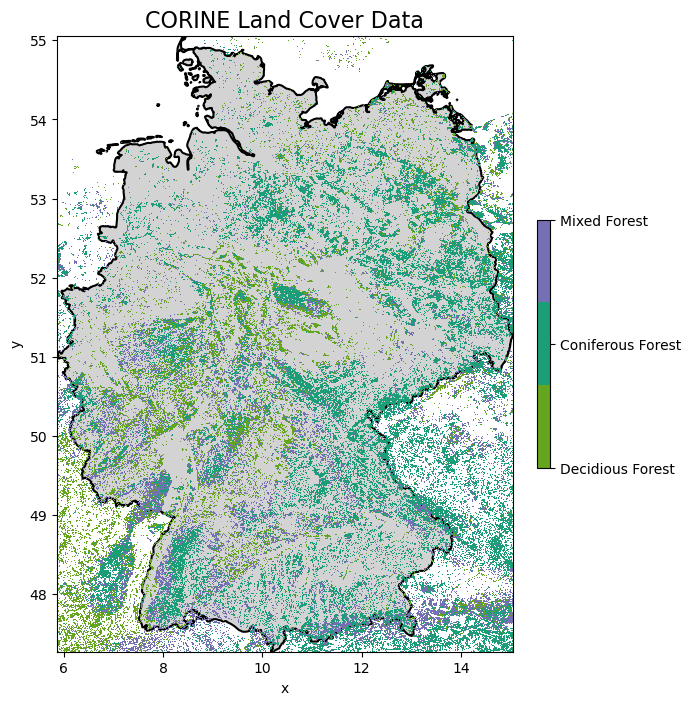

In [32]:
# Load the germany border shapefile
germany_gpd = gpd.read_file(germany_shp_path)

# Load the CORINE land cover data
corine_raster = rio.open_rasterio(corine_file_path)

# set 0 to na
corine_raster = corine_raster.where(corine_raster != 0)

# create parameters for plotting
cmap = ListedColormap(['#66a61e', '#1b9e77', '#7570b3'])
vmin = 311; vmax = 313
legend_labels=['Decidious Forest', 'Coniferous Forest', 'Mixed Forest']


# Plot the CORINE land cover data with the Germany border overlayed
fig, ax = plt.subplots(figsize=(8, 8))

# Plot Germany with gray fill and black boundary
germany_gpd.plot(ax=ax, color='lightgray', edgecolor='black', alpha=1, linewidth=1.5)

# Plot corine data
corine_raster.plot(ax=ax, alpha=1, vmin=vmin, vmax=vmax, cmap= cmap, add_colorbar=False)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=cmap),
                    ax=ax, fraction=0.02, pad=0.04)


# set title
ax.set_title("CORINE Land Cover Data", fontsize=16)

# Change color bar
ticks = np.linspace(vmin, vmax, len(legend_labels))
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels(legend_labels)

plt.show()



</br>

## Preprocessing the cube 

Next we preprocessed the subsetted data cube. 

This includes:

- croping the cube with the german border shape
 
- masking the cube with the corine forest cover:
   
  - Calculate the forest percentage of the Corine landcover data over the cube grid
  - add the forest percentages to the cube
  - add a binary forest cover layer to the cube (0 for <50% forest cover, 1 for >=50% forest cover)
  - use the layer to mask the cube

The results are cube_subset_crop which is croped with the germany border and cube_subset_mask, masked with the forest cover.

Details: [2 Preprocessing ESDC](#sec-cube_preproc)

***

**Visualization of Corine Data Processing.**

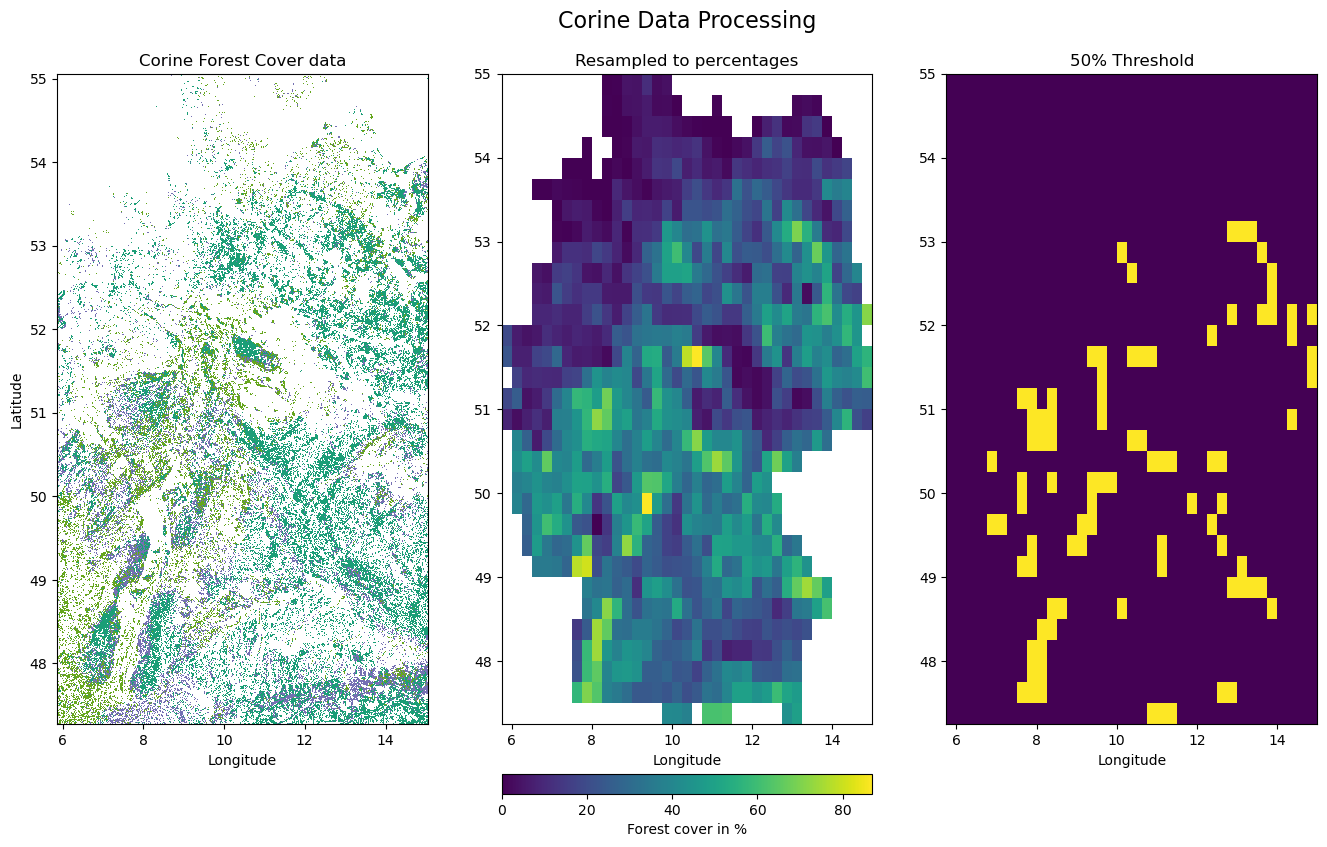

In [33]:
# Load cube subset croped and cube subset mask
cube_subset_crop = xr.open_dataset(cube_crop_path)
cube_subset_mask = xr.open_dataset(cube_crop_mask_path)

# Load the forest percentages raster
forest_percentages = rio.open_rasterio(cube_crop_path.replace(".nc", "_percentages.tif"))

# Create a grid spec with extra space at the bottom
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 3, height_ratios=[1, 0.03], hspace=0.15)

# Create subplots in the grid spec
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

# Plot rasterio dataset
corine_raster.plot(ax=ax0, alpha=1, vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
ax0.set_title("Corine Forest Cover data")
ax0.set_ylabel("Latitude")
ax0.set_xlabel("Longitude")

# Plot the forest percentages raster
forest_im = forest_percentages.plot(ax=ax1, alpha=1, add_colorbar=False)
ax1.set_title("Resampled to percentages")
ax1.set_ylabel("")
ax1.set_xlabel("Longitude")

# Add a colorbar at the bottom for the forest percentages raster
cax = fig.add_subplot(gs[1, 1])  # Add a subplot in the second row, middle column
cbar = fig.colorbar(forest_im, cax=cax, orientation='horizontal')
cbar.set_label("Forest cover in %")

# Plot the forest cover 50% threshold
cube_subset_crop.forest_cover_50.plot(ax=ax2, vmin=0, add_colorbar=False)
ax2.set_title("50% Threshold")
ax2.set_ylabel("")
ax2.set_xlabel("Longitude")

# Main title for the entire figure
fig.suptitle("Corine Data Processing", fontsize=16)

# Adjust the layout to ensure everything fits well
plt.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0)
plt.show()



***

**Showing examplary timestep of croped and masked + croped cube**

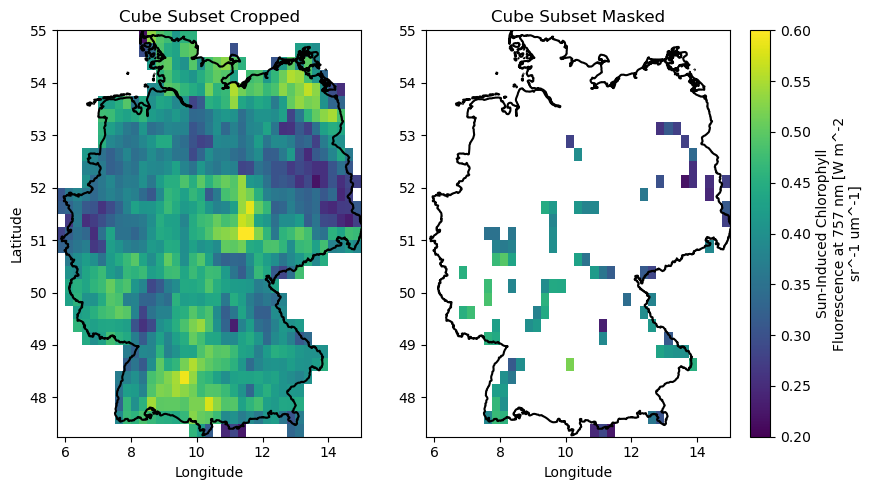

In [34]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))


# Plot the croped dataset
im = cube_subset_crop.sif_gosif.isel(time=20).plot(ax=axes[0],vmin=0.2,vmax=0.6, add_colorbar=False, cmap='viridis')
axes[0].set_title("Cube Subset Cropped")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Plot the masked dataset
cube_subset_mask.sif_gosif.isel(time=20).plot(ax=axes[1],vmin=0.2,vmax=0.6, add_colorbar=True, cmap='viridis')
axes[1].set_title("Cube Subset Masked")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("")

# Add germany border
germany_gpd.plot(ax=axes[0], edgecolor='black', alpha=1, linewidth=1.5, facecolor = "none")
germany_gpd.plot(ax=axes[1], edgecolor='black', alpha=1, linewidth=1.5, facecolor = "none" )

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust rect to make room for the colorbar
plt.show()



</br>

## Basic Analysis of SIF-Data

The next step in our analysis was to 
  
- Perform a change detection by calculating the summer mean for each year and the change for the year 2018 to the baseline up to 2017
  

Details: ["3 Basic SIF Analysis"](#-src-base)

***

**Plot summer means for the SIF variable for the reference period 2000-2017, 2018 and the difference of them.**

We can see that the SIF values are lower in 2018 compared to the reference period, all over germany, except in some small areas, mostly in the Alps. This overlaps with our expectation, although this methodology does not relate the change to the Heatwave, but only shows that 2018 was a year with comparably low SIF over germany.

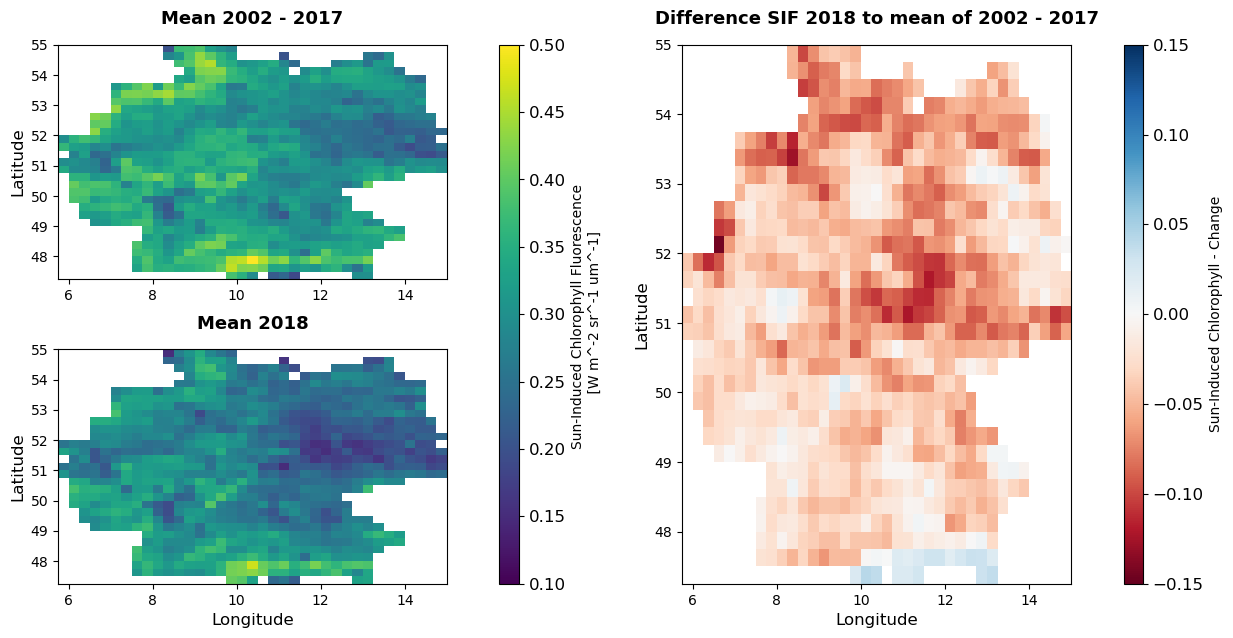

In [42]:
# Calculate the temporal changes in the variables using from s03_base_analysis.py
summer_sif_mean_cube, summer_mean_to_2017, changes = base_analysis(cube_subset_crop, years=[2018, 2019])

# Select only year 2018 from mean over summer months
summer_mean_2018 = summer_sif_mean_cube.sel(year=2018)

# Plot the changes using the function defined in s03_base_analysis.py
change_plot(ref_period = summer_mean_to_2017, data_2018 = summer_mean_2018, changes = changes);

*** 

**Plot Sif Time series (mean over masked cells in germany)**

In the timeseries we can see also see that the year 2018 had comparably low SIF values in the summer months compared to the preceeding years.

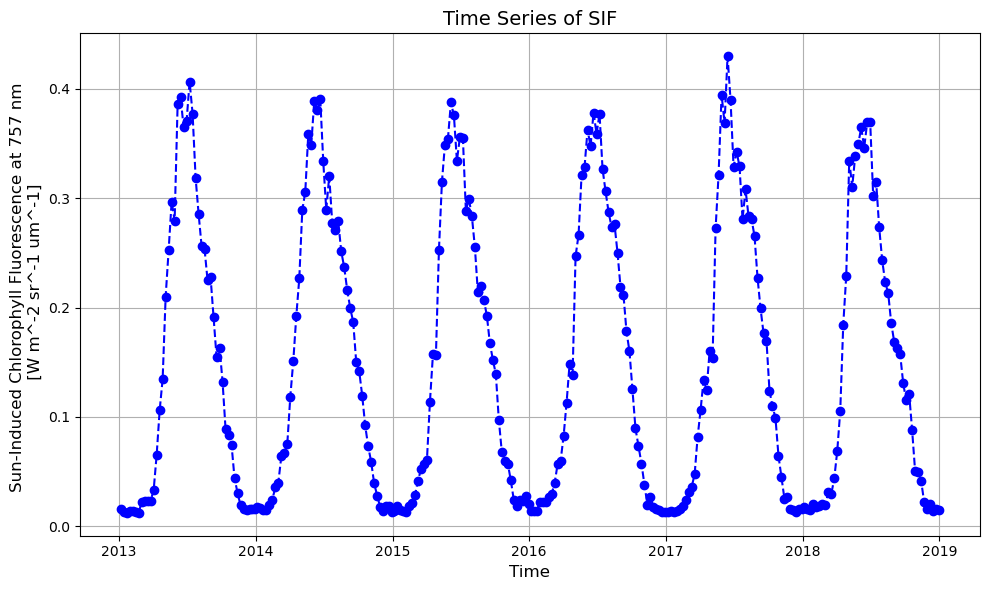

In [41]:
# Create plot of timeseries
plot_timeseries(cube_subset_mask, time_range= ["2013-01-01", "2018-12-31"], save_path = os.path.join("results", "figures", "timeseries_recent.png"))


</br>

## Prelimnary Modelling

To determine what is the appropriate model structure, we tested for different approaches.

Four general model setups were tested. These are differing in whether they are global or local models and whether they have an auto regressive component or not, meaning whether they encoperate a shifted version of the target variable (SIF) as a predictor.


To find the best hyperparameters 3 look back periods were tested and a grid search cross-validation was done.

Details: [5 Prelimnary Modelling](#-src_prelim)

*** 

**Table showing mae and rmse model performances**

We can see that the local models clearly performed better. For that reason global models were not further considered.

In [37]:
import os
import json
from collections import defaultdict

# Function to read JSON files and extract relevant data
def read_json_files(base_dir):
    # Initialize a dictionary to store the extracted data
    results = {
        "results_l15": {"auto": [], "noauto": []},
        "results_l30": {"auto": [], "noauto": [], "global_auto": [], "global_noauto": []},
        "results_l45": {"auto": [], "noauto": []},
    }

    # Traverse through the base directory and subdirectories
    for lookback_dir in ["results_l15", "results_l30", "results_l45"]:
        lookback_path = os.path.join(base_dir, lookback_dir)
        if not os.path.isdir(lookback_path):
            continue

        # Identify files containing "auto", "noauto", or "global" in their names
        for filename in os.listdir(lookback_path):
            if "global" in filename:
                continue

            if "noauto" in filename:
                key = "noauto"
            elif "auto" in filename:
                key = "auto"
            else:
                continue

            file_path = os.path.join(lookback_path, filename)

            # Read and parse the JSON file
            with open(file_path, 'r') as file:
                data = json.load(file)

                # Extract relevant data and store it in the results dictionary
                for location, details in data.items():
                    result_entry = {
                        "location": location,
                        "best_params": details.get("best_params", {}),
                        "look_back": details.get("look_back", 0),
                        "evaluation": details.get("evaluation", {}),
                    }
                    results[lookback_dir][key].append(result_entry)

    return results

# Function to calculate mean performance metrics
def calculate_mean_performance(results):
    # Initialize dictionaries to store the sum and count of performance metrics
    performance_sums = defaultdict(lambda: {"mae": 0, "rmse": 0, "count": 0})
    mean_performance = {}

    # Sum the performance metrics and count the number of entries
    for lookback in results:
        for auto_type in results[lookback]:
            for entry in results[lookback][auto_type]:
                evaluation = entry["evaluation"]
                if "mae" in evaluation and "rmse" in evaluation:
                    performance_sums[f"{lookback}_{auto_type}"]["mae"] += evaluation["mae"]
                    performance_sums[f"{lookback}_{auto_type}"]["rmse"] += evaluation["rmse"]
                    performance_sums[f"{lookback}_{auto_type}"]["count"] += 1

    # Calculate the mean performance metrics
    for key, sums in performance_sums.items():
        if sums["count"] > 0:
            mean_performance[key] = {
                "mean_mae": np.round(sums["mae"] / sums["count"], 4),
                "mean_rmse": np.round(sums["rmse"] / sums["count"], 4)
            }
        else:
            mean_performance[key] = {"mean_mae": None, "mean_rmse": None}

    return mean_performance

# Base directory where the results folders are located
base_dir = os.path.join("results", "modelling")

# Read JSON files and extract data
results_data = read_json_files(base_dir)

# Calculate mean performance metrics
mean_performance_data = calculate_mean_performance(results_data)


globa_auto_path = os.path.join(base_dir, "results_l30", "results_global_auto_l30.json")
global_noauto_path = os.path.join(base_dir, "results_l30", "results_global_noauto_l30.json")

def get_mae_rmse_from_json(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    return np.round(data["evaluation"]["mae"],3), np.round(data["evaluation"]["rmse"],3)

global_results = get_mae_rmse_from_json(globa_auto_path), get_mae_rmse_from_json(global_noauto_path)

import pandas as pd
# Convert the dictionary to a DataFrame
data = []
for key, values in mean_performance_data.items():
    lookback, auto_type = key.rsplit('_', 1)
    data.append({
        'model' : 'local',
        'lookback': lookback[-2:],
        'type': auto_type,
        'mean_mae': values['mean_mae'],
        'mean_rmse': values['mean_rmse']
    })

# Add global results to the data
data.append({
    'model' : 'global',
    'lookback': '30',
    'type': 'auto',
    'mean_mae': global_results[0][0],
    'mean_rmse': global_results[0][1]
})
data.append({
    'model' : 'global',
    'lookback': '30',
    'type': 'noauto',
    'mean_mae': global_results[1][0],
    'mean_rmse': global_results[1][1]
})

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

    model lookback    type  mean_mae  mean_rmse
0   local       15    auto    0.0150     0.0217
1   local       15  noauto    0.0161     0.0228
2   local       30    auto    0.0144     0.0212
3   local       30  noauto    0.0142     0.0210
4   local       45    auto    0.0149     0.0218
5   local       45  noauto    0.0145     0.0211
6  global       30    auto    0.0330     0.0450
7  global       30  noauto    0.0330     0.0500


*** 

**Comparison between local models.**

The plot below shows the mean performances of all local models. The local model without autoregressive component and a lookback period of 30 was selected as the best model setup.

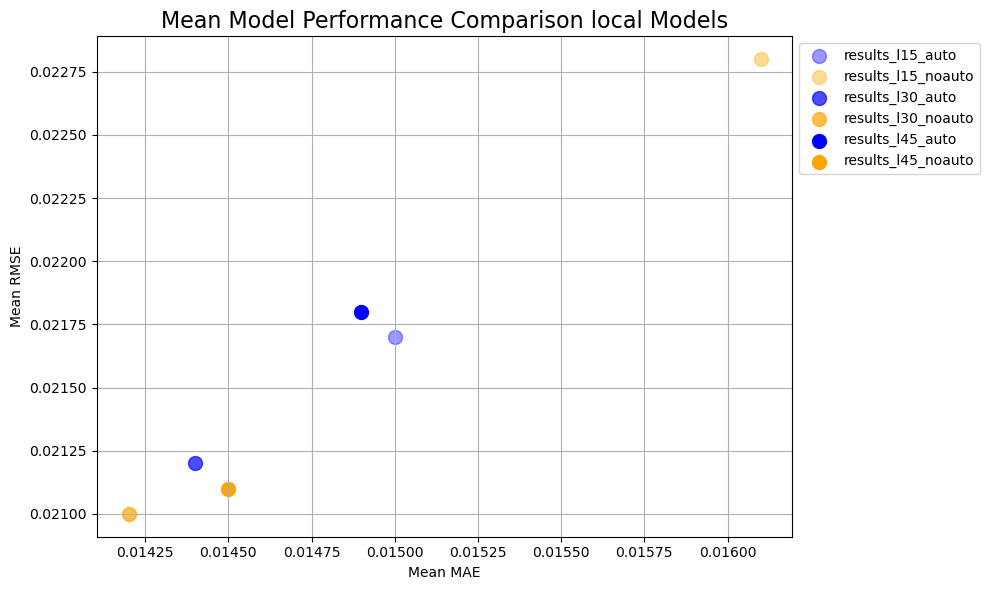

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def plot_performance_data(mean_performance_data):
    # Define colors and markers
    colors = {
        'auto': "blue",
        'noauto': "orange"
    }
    shades = {
        'results_l15': 0.4,
        'results_l30': 0.7,
        'results_l45': 1
    }
    markers = ['o', 's', 'D', '^']

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot data for each key in the mean performance data
    for idx, (key, performance) in enumerate(mean_performance_data.items()):
        lookback, auto_type = key.rsplit('_', 1)
        color = colors[auto_type]
        shade = shades[lookback]

        plt.scatter(performance['mean_mae'], performance['mean_rmse'], 
                    color=color, alpha=shade, label=key, s=100)



    # Add labels and title
    plt.xlabel('Mean MAE')
    plt.ylabel('Mean RMSE')
    plt.title('Mean Model Performance Comparison local Models', fontsize=16)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()

    # Show plot
    plt.show()

# Call the function to plot the data
plot_performance_data(mean_performance_data)


</br>

## Final Modelling

Based on the prelimary results a local model with a lookback of 30 time steps (30 * 8 days = 240 days) was chosen.

The modelling setup was the same as before, except that  now the model was fitted for all locations and the number of hyperparameters was reduced. In the prelimnary results the hyperparameters of using 3 lstm layers, and relu as an activation function never were selected as the best hyperparameters. Therefore they were no longer considered.

Details: [5 Final Modelling](#-src-model)

*** 

**Calculate mean RMSE and MAE**

The RMSE and MAE show the model achieved a good fit with a mean RMSE of 0.02 and a mean MAE of 0.014.

In [39]:
# Reading the results and evaluation from the file
with open("results/modelling/final/results_full_local_auto_l30.json", 'r') as file:
    results_dict = json.load(file)

rmse_values = {loc: data['evaluation']['rmse'] for loc, data in results_dict.items()}
mae_values = {loc: data['evaluation']['mae'] for loc, data in results_dict.items()}

mean_rmse = np.mean(list(rmse_values.values()))
mean_mae = np.mean(list(mae_values.values()))

print(f"Mean RMSE: {mean_rmse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")

Mean RMSE: 0.020
Mean MAE: 0.014


***

**Plotting timerseries for the best and worst performing models**

In the plot below showing the two best and worst performing models, we can also that the forecasted values match well with the true values. Even so for the two worst performing models. We can however observe that steep increases or decreases in SIF were in many cases not well predicted.

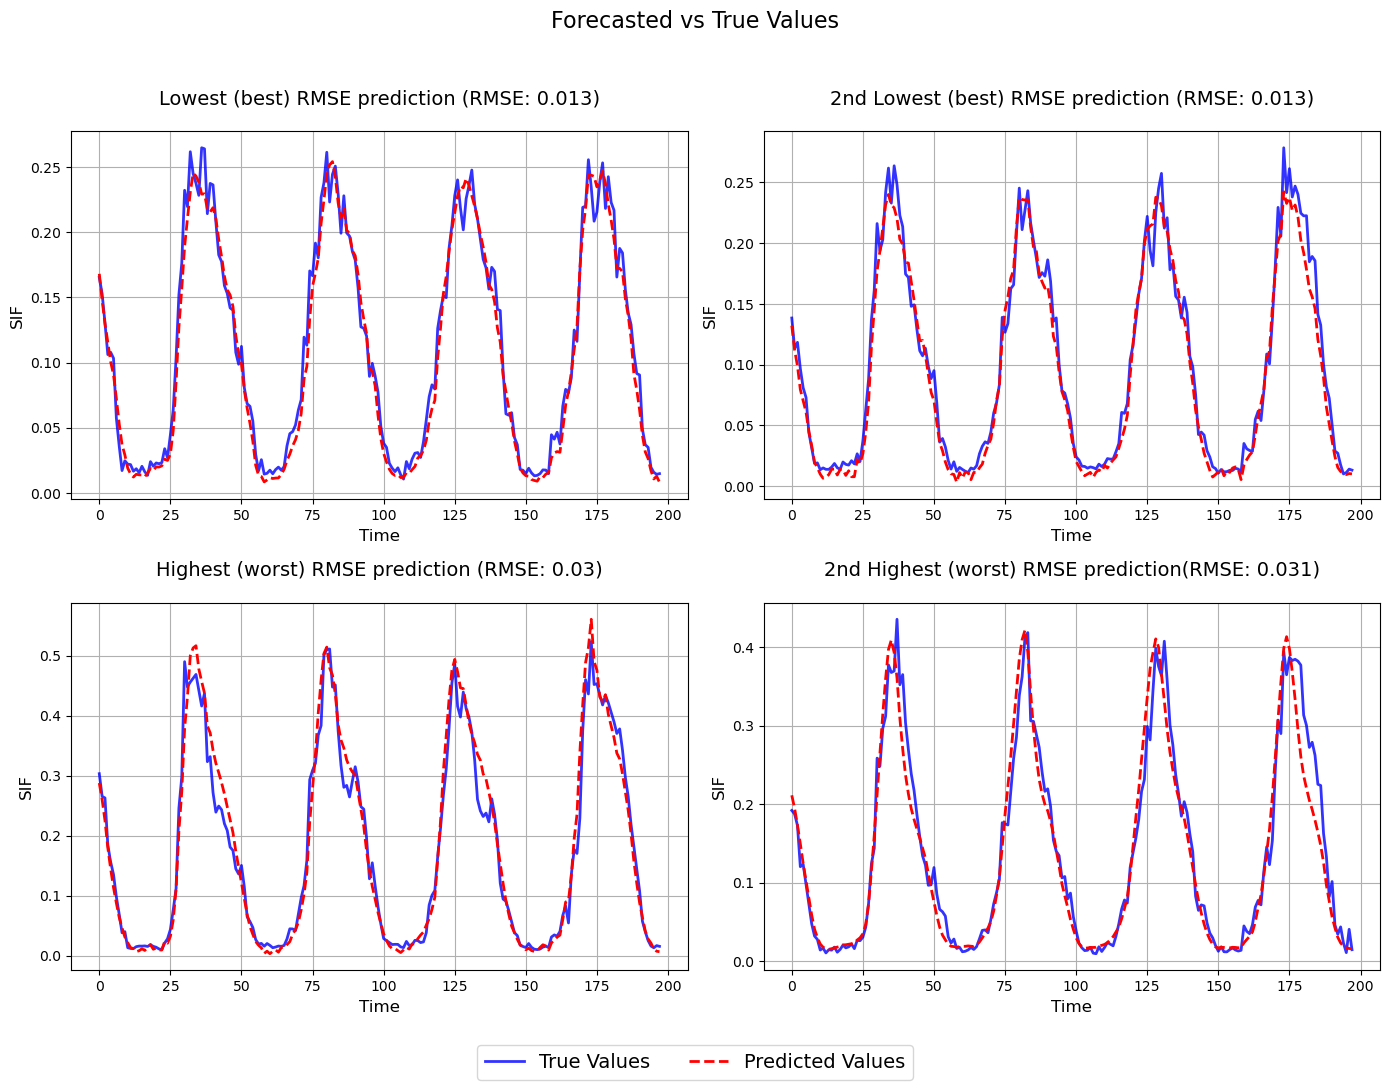

In [40]:


def plot_forecasts_from_dict(results_dict):
    """
    This function takes a dictionary containing model results and creates plots for the two locations
    with the highest and two locations with the lowest RMSE values.

    Args:
    results_dict (dict): Dictionary containing model results with true and predicted values.

    Returns:
    None
    """
    # Extract RMSEs and corresponding locations
    rmse_values = {loc: data['evaluation']['rmse'] for loc, data in results_dict.items()}

    # Sort locations by RMSE
    sorted_locations = sorted(rmse_values, key=rmse_values.get)

    # Find two locations with highest and two with lowest RMSE
    lowest_rmse_locations = sorted_locations[:2]
    highest_rmse_locations = sorted_locations[-2:]

    # Function to plot true vs predicted values
    def plot_forecast(true_values, predicted_values, title, ax):
        line1, = ax.plot(true_values, label='True Values', color='blue',alpha=0.8, linewidth=2)
        line2, = ax.plot(predicted_values, label='Predicted Values', color='red', alpha=1, linestyle='--', linewidth=2)
        ax.set_title(title, fontsize=14, y = 1.05)
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('SIF', fontsize=12)
        ax.grid(True)
        return line1, line2


    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    # Plot for locations with lowest RMSE
    lines = []
    for i, loc in enumerate(lowest_rmse_locations):
        rmse = np.round(results_dict[loc]['evaluation']['rmse'],3)
        true_values = results_dict[loc]['results']['true_values']
        predicted_values = results_dict[loc]['results']['predicted_values']
        line1, line2 = plot_forecast(
            [val[0] for val in true_values],
            [val[0] for val in predicted_values],
            f'Lowest (best) RMSE prediction (RMSE: {rmse})'if i == 0 else f'2nd Lowest (best) RMSE prediction (RMSE: {rmse})',
            ax=axs[0, i]
        )
        lines.append((line1, line2))

    # Plot for locations with highest RMSE
    for i, loc in enumerate(highest_rmse_locations):
        rmse = np.round(results_dict[loc]['evaluation']['rmse'],3)
        true_values = results_dict[loc]['results']['true_values']
        predicted_values = results_dict[loc]['results']['predicted_values']
        line1, line2 = plot_forecast(
            [val[0] for val in true_values],
            [val[0] for val in predicted_values],
            f'Highest (worst) RMSE prediction (RMSE: {rmse})' if i == 0 else f'2nd Highest (worst) RMSE prediction(RMSE: {rmse})',
            ax=axs[1, i]
        )
        lines.append((line1, line2))

    # Add a main title
    fig.suptitle('Forecasted vs True Values', fontsize=16, y=0.95)



    # Add a single shared legend
    #fig.legend([lines[0][0], lines[0][1]], ['True Values', 'Predicted Values'], loc='lower center', fontsize=12)
    fig.legend([lines[0][0], lines[0][1]], ['True Values', 'Predicted Values'], loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=2,
               fontsize = 14)

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0.1, 1, 0.93])
    plt.show()

    plt.save('results/figures/forecasted_vs_true_values.png')

# Call the function with the example dictionary
plot_forecasts_from_dict(results_dict)

